In [57]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [59]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [60]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [61]:
tf.keras.backend.clear_session()

In [62]:
subject = 'Acre - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [63]:
data = pd.read_csv('2003_mo_model_input_AC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Acre - Consumo de Cimento (t),Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,3.260,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,2.191,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,2.154,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,2.643,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,2.546,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,39738.391869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,39713.363501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,39639.488252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,39545.723370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


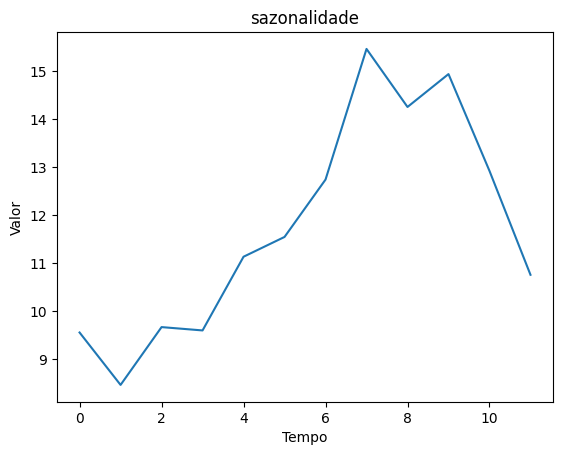

,sazonalidade
sazonalidade,
0,9.561256
1,8.471380
2,9.673557
3,9.604246
4,11.136574
5,11.548054
6,12.740705
7,15.457246
8,14.250442


In [64]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [65]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Acre - Consumo de Cimento (t)
0,2003-1,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,9.561256,3.260
1,2003-2,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.471380,2.191
2,2003-3,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.673557,2.154
3,2003-4,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.604246,2.643
4,2003-5,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,11.136574,2.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39738.391869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.136574,NaN
245,2023-6,39713.363501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.548054,NaN
246,2023-7,39639.488252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.740705,NaN
247,2023-8,39545.723370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.457246,NaN


In [66]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      5.807
1      5.242
2      4.965
3      5.854
4      5.892
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Acre - Consumo de Cimento (t), Length: 249, dtype: float64

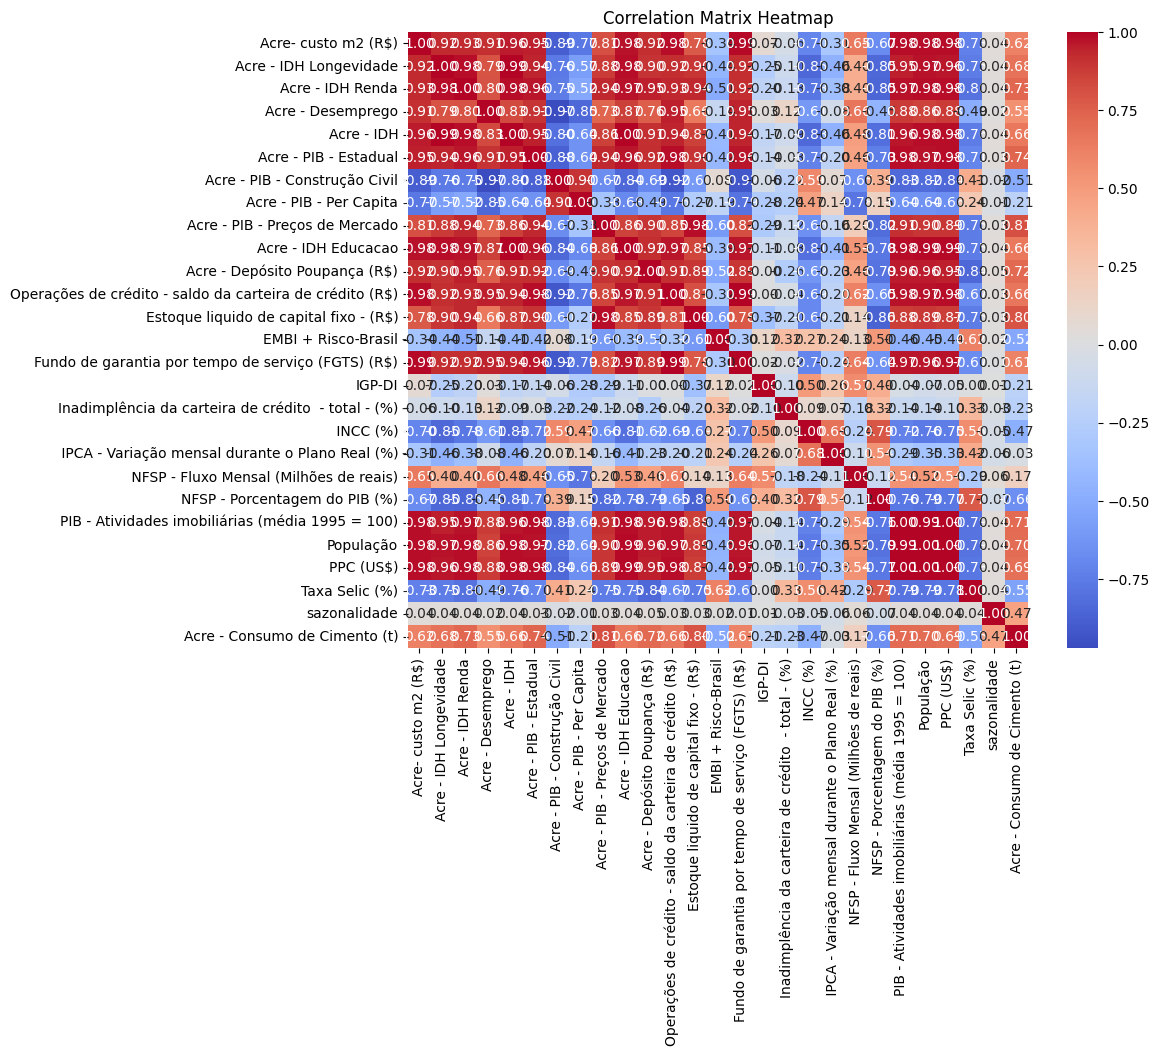

In [67]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [69]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Acre- custo m2 (R$),2.734235e+04
1,Acre - IDH Longevidade,2.061308e+08
2,Acre - IDH Renda,8.445457e+07
3,Acre - Desemprego,7.756149e+02
4,Acre - IDH,9.752282e+08
5,Acre - PIB - Estadual,7.781600e+04
6,Acre - PIB - Construção Civil,4.324588e+03
7,Acre - PIB - Per Capita,8.683447e+03
8,Acre - PIB - Preços de Mercado,2.825924e+04
9,Acre - IDH Educacao,1.300066e+08


In [70]:
# data =data.drop(['Acre- custo m2 (R$)',
#                  'Acre - IDH Longevidade',
#                  'Acre - IDH Renda', 
#                  'Acre - PIB - Estadual'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 0


,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,9.561256
1,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.471380
2,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.673557
3,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.604246
4,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,11.136574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,30581.002422,0.802304,0.662345,11.963821,0.718275,8.511416e+06,394892.883362,9.235197,6.785309e+06,0.697926,838864.153973,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,15.457246
200,30806.802063,0.802104,0.662247,11.952119,0.718126,8.504038e+06,395105.508031,9.236020,6.784281e+06,0.697710,855696.157670,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,14.250442
201,31041.938620,0.801905,0.662149,11.940417,0.717977,8.496660e+06,395318.132700,9.236843,6.783254e+06,0.697493,872528.161366,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,14.934176
202,31282.201167,0.801706,0.662051,11.928715,0.717828,8.489281e+06,395530.757369,9.237666,6.782226e+06,0.697277,889360.165063,3.425371e+06,7.700533e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,2.008405e+08,439.704663,0.441494,12.920681


In [71]:
input_data = data
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.509727,-2.415882,-2.356162,-0.871260,-2.233199,-1.827644,0.550935,-0.265790,-2.404401,-2.033439,-1.815821,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-0.994933
1,-1.496661,-2.372431,-2.318388,-0.874207,-2.196498,-1.807633,0.567407,-0.242610,-2.361200,-2.005361,-1.809732,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-1.489238
2,-1.484420,-2.328980,-2.280615,-0.877154,-2.159796,-1.787622,0.583879,-0.219431,-2.317998,-1.977284,-1.803643,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-0.944001
3,-1.472301,-2.285529,-2.242841,-0.880101,-2.123094,-1.767611,0.600352,-0.196252,-2.274796,-1.949206,-1.797554,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-0.975436
4,-1.459282,-2.242078,-2.205067,-0.883048,-2.086392,-1.747600,0.616824,-0.173072,-2.231595,-1.921128,-1.791465,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-0.280461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.767034,0.848464,0.963521,1.086583,1.093639,0.845955,-0.984945,-1.492171,0.341015,1.238509,1.709523,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268,1.679145
200,1.803434,0.826218,0.932813,1.079514,1.075237,0.829861,-0.967308,-1.480041,0.326774,1.225428,1.809807,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925,1.131808
201,1.841339,0.803973,0.902105,1.072445,1.056835,0.813767,-0.949672,-1.467910,0.312533,1.212348,1.910091,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663,1.441910
202,1.880070,0.781727,0.871397,1.065376,1.038433,0.797673,-0.932035,-1.455780,0.298292,1.199267,2.010375,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340,0.528706


In [72]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.509727,-2.415882,-2.356162,-0.871260,-2.233199,-1.827644,0.550935,-0.265790,-2.404401,-2.033439,-1.815821,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-0.994933
1,-1.496661,-2.372431,-2.318388,-0.874207,-2.196498,-1.807633,0.567407,-0.242610,-2.361200,-2.005361,-1.809732,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-1.489238
2,-1.484420,-2.328980,-2.280615,-0.877154,-2.159796,-1.787622,0.583879,-0.219431,-2.317998,-1.977284,-1.803643,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-0.944001
3,-1.472301,-2.285529,-2.242841,-0.880101,-2.123094,-1.767611,0.600352,-0.196252,-2.274796,-1.949206,-1.797554,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-0.975436
4,-1.459282,-2.242078,-2.205067,-0.883048,-2.086392,-1.747600,0.616824,-0.173072,-2.231595,-1.921128,-1.791465,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-0.280461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.445743,1.086763,1.091285,1.162031,1.281085,1.009833,-1.186919,-1.574562,0.511942,1.343841,0.937708,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820,1.679145
188,1.465647,1.070247,1.108723,1.156838,1.269359,0.999589,-1.171215,-1.575066,0.497694,1.341087,0.951673,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503,1.131808
189,1.486774,1.053732,1.126162,1.151646,1.257632,0.989345,-1.155512,-1.575570,0.483445,1.338333,0.965639,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444,1.441910
190,1.510055,1.037216,1.143600,1.146453,1.245906,0.979101,-1.139808,-1.576074,0.469197,1.335579,0.979604,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935,0.528706


In [73]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       5.807
1       5.242
2       4.965
3       5.854
4       5.892
        ...  
187    20.279
188    18.042
189    20.063
190    13.998
191    12.751
Name: Acre - Consumo de Cimento (t), Length: 192, dtype: float64

In [74]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [75]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 26)

In [76]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
156,0.908276,1.414892,1.215899,1.385161,1.309555,1.084671,-1.469671,-1.315392,0.681935,1.249466,0.516600,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265,-0.994933
157,0.925302,1.408445,1.190210,1.374475,1.306773,1.086706,-1.469650,-1.329789,0.680012,1.246767,0.515288,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084,-1.489238
158,0.942391,1.401997,1.164522,1.363788,1.303991,1.088741,-1.469629,-1.344186,0.678089,1.244068,0.513975,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087,-0.944001
159,0.960170,1.395550,1.138834,1.353101,1.301208,1.090776,-1.469609,-1.358583,0.676166,1.241369,0.512662,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300,-0.975436
160,0.977608,1.389102,1.113146,1.342415,1.298426,1.092812,-1.469588,-1.372980,0.674243,1.238670,0.511350,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403,-0.280461
161,0.994881,1.382655,1.087458,1.331728,1.295644,1.094847,-1.469567,-1.387377,0.672320,1.235971,0.510037,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434,-0.093837
162,1.010732,1.376207,1.061770,1.321042,1.292862,1.096882,-1.469547,-1.401773,0.670397,1.233272,0.508725,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553,0.447079
163,1.026286,1.369760,1.036081,1.310355,1.290080,1.098918,-1.469526,-1.416170,0.668474,1.230573,0.507412,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038,1.679145
164,1.042106,1.363312,1.010393,1.299668,1.287297,1.100953,-1.469505,-1.430567,0.666551,1.227875,0.506100,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412,1.131808
165,1.059093,1.356865,0.984705,1.288982,1.284515,1.102988,-1.469485,-1.444964,0.664628,1.225176,0.504787,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764,1.441910


In [77]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 26)

In [78]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [79]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [80]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [81]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3685048997, 2560710562, 1049569209, 4040581760, 3577997783, 3615450295, 2719007342, 2297477252, 1519112434, 2881948254]


Step: 0 ___________________________________________
val_loss: 7.583410263061523
winner_seed: 3685048997


Step: 1 ___________________________________________
val_loss: 8.09266471862793


Step: 2 ___________________________________________
val_loss: 5.238846778869629
winner_seed: 1049569209


Step: 3 ___________________________________________
val_loss: 5.355640888214111


Step: 4 ___________________________________________
val_loss: 7.798616409301758


Step: 5 ___________________________________________
val_loss: 4.7629899978637695
winner_seed: 3615450295


Step: 6 ___________________________________________
val_loss: 3.8068366050720215
winner_seed: 2719007342


Step: 7 ___________________________________________
val_loss: 5.1736602783203125


Step: 8 ___________________________________________
val_loss: 8.640883445739746


Step: 9 _________________________________

In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 95ms/step - loss: 171.9781 - val_loss: 84.4927
Epoch 2/10000
5/5 [==============================] - 0s 11ms/step - loss: 32.5173 - val_loss: 21.8088
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.8335 - val_loss: 18.8430
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.0224 - val_loss: 18.8788
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.5326 - val_loss: 20.4904
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.0890 - val_loss: 21.2918
Epoch 7/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.3589 - val_loss: 19.0419
Epoch 8/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.1183 - val_loss: 27.0978
Epoch 9/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3385 - val_loss: 23.2887
Epoch 10/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.1956 

Epoch 82/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.0652 - val_loss: 9.0666
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.8548 - val_loss: 11.5268
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.5908 - val_loss: 9.2580
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.9152 - val_loss: 8.2206
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.0194 - val_loss: 8.0867
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.8683 - val_loss: 9.4165
Epoch 88/10000
5/5 [==============================] - 0s 10ms/step - loss: 3.9196 - val_loss: 9.3054
Epoch 89/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.3948 - val_loss: 9.0363
Epoch 90/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.5092 - val_loss: 9.6106
Epoch 91/10000
5/5 [==============================] - 0s 10ms/step - loss: 3.4501 - val_loss: 8.6

Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.2877 - val_loss: 11.9825
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.4295 - val_loss: 10.3045
Epoch 165/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.9464 - val_loss: 10.0542
Epoch 166/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.1715 - val_loss: 8.7314
Epoch 167/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.2422 - val_loss: 9.9877
Epoch 168/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.4398 - val_loss: 11.6652
Epoch 169/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.4955 - val_loss: 9.8242
Epoch 170/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.2018 - val_loss: 10.1931
Epoch 171/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.1358 - val_loss: 11.2333
Epoch 172/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.0160 - v

5/5 [==============================] - 0s 9ms/step - loss: 2.9483 - val_loss: 10.1305
Epoch 244/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.9873 - val_loss: 13.9138
Epoch 245/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.0151 - val_loss: 13.4884
Epoch 246/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.9915 - val_loss: 9.7041
Epoch 247/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7840 - val_loss: 11.9602
Epoch 248/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.9632 - val_loss: 8.9304
Epoch 249/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.9495 - val_loss: 11.3231
Epoch 250/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7490 - val_loss: 9.5029
Epoch 251/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.0378 - val_loss: 9.7218
Epoch 252/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.0532 - val_loss: 8.7836
E

Epoch 324/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5845 - val_loss: 9.5866
Epoch 325/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.9239 - val_loss: 12.0298
Epoch 326/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.8947 - val_loss: 9.5765
Epoch 327/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5274 - val_loss: 9.0217
Epoch 328/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.8799 - val_loss: 9.6856
Epoch 329/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.7830 - val_loss: 8.8350
Epoch 330/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.7723 - val_loss: 11.6928
Epoch 331/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.8689 - val_loss: 9.3494
Epoch 332/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.7235 - val_loss: 8.8852
Epoch 333/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.1790 - 

5/5 [==============================] - 0s 10ms/step - loss: 2.8015 - val_loss: 9.1295
Epoch 405/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.6694 - val_loss: 8.9780
Epoch 406/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7223 - val_loss: 8.4282
Epoch 407/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7379 - val_loss: 9.1681
Epoch 408/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.6824 - val_loss: 9.1615
Epoch 409/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5968 - val_loss: 9.3175
Epoch 410/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7141 - val_loss: 9.8121
Epoch 411/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.6926 - val_loss: 10.1200
Epoch 412/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.7929 - val_loss: 8.6118
Epoch 413/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7901 - val_loss: 9.8619
Epo

Epoch 485/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7065 - val_loss: 8.5278
Epoch 486/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5554 - val_loss: 9.2281
Epoch 487/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.5994 - val_loss: 9.1919
Epoch 488/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.8590 - val_loss: 12.2478
Epoch 489/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.6672 - val_loss: 8.1105
Epoch 490/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.6103 - val_loss: 8.4180
Epoch 491/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7365 - val_loss: 9.3308
Epoch 492/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.5621 - val_loss: 9.5934
Epoch 493/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5921 - val_loss: 9.1213
Epoch 494/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3668 - va

5/5 [==============================] - 0s 8ms/step - loss: 2.3320 - val_loss: 9.6014
Epoch 566/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3541 - val_loss: 8.8226
Epoch 567/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4814 - val_loss: 8.6866
Epoch 568/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4007 - val_loss: 10.1960
Epoch 569/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4642 - val_loss: 9.3635
Epoch 570/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5572 - val_loss: 9.6124
Epoch 571/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4431 - val_loss: 10.4812
Epoch 572/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.4066 - val_loss: 9.9050
Epoch 573/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3563 - val_loss: 9.5419
Epoch 574/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3751 - val_loss: 8.9282
Epoc

Epoch 646/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.2510 - val_loss: 8.9115
Epoch 647/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3545 - val_loss: 9.3443
Epoch 648/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.4224 - val_loss: 9.4359
Epoch 649/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2710 - val_loss: 8.4923
Epoch 650/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.5565 - val_loss: 8.5596
Epoch 651/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3833 - val_loss: 9.4525
Epoch 652/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4242 - val_loss: 10.7443
Epoch 653/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4639 - val_loss: 10.4510
Epoch 654/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.3723 - val_loss: 8.1390
Epoch 655/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.5409 - v

5/5 [==============================] - 0s 9ms/step - loss: 2.1762 - val_loss: 9.2005
Epoch 727/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2135 - val_loss: 10.4107
Epoch 728/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2549 - val_loss: 9.8482
Epoch 729/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3867 - val_loss: 9.0071
Epoch 730/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2851 - val_loss: 10.1976
Epoch 731/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0652 - val_loss: 9.2977
Epoch 732/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2840 - val_loss: 9.2010
Epoch 733/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3570 - val_loss: 10.3467
Epoch 734/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2755 - val_loss: 9.0151
Epoch 735/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0691 - val_loss: 9.0433
Epo

Epoch 807/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.1478 - val_loss: 9.4188
Epoch 808/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.9977 - val_loss: 8.4963
Epoch 809/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1767 - val_loss: 8.6206
Epoch 810/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1338 - val_loss: 8.4425
Epoch 811/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1101 - val_loss: 10.4476
Epoch 812/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.0991 - val_loss: 10.0332
Epoch 813/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1254 - val_loss: 9.2018
Epoch 814/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1768 - val_loss: 8.5706
Epoch 815/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.1969 - val_loss: 9.3821
Epoch 816/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1696 - val_

5/5 [==============================] - 0s 8ms/step - loss: 2.0723 - val_loss: 7.6789
Epoch 888/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.0629 - val_loss: 8.6667
Epoch 889/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.1896 - val_loss: 8.7436
Epoch 890/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0458 - val_loss: 7.7218
Epoch 891/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.0534 - val_loss: 10.2857
Epoch 892/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1033 - val_loss: 8.1548
Epoch 893/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9990 - val_loss: 9.8561
Epoch 894/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1502 - val_loss: 9.1072
Epoch 895/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.1711 - val_loss: 8.2804
Epoch 896/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0712 - val_loss: 7.6650
Ep

5/5 [==============================] - 0s 9ms/step - loss: 2.0040 - val_loss: 6.9682
Epoch 969/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0614 - val_loss: 7.3961
Epoch 970/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9766 - val_loss: 8.3736
Epoch 971/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9114 - val_loss: 7.7432
Epoch 972/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8936 - val_loss: 6.9278
Epoch 973/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.8191 - val_loss: 7.9739
Epoch 974/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.8930 - val_loss: 7.2763
Epoch 975/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0271 - val_loss: 8.7028
Epoch 976/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9373 - val_loss: 7.0000
Epoch 977/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0611 - val_loss: 8.8928
Epoc

5/5 [==============================] - 0s 9ms/step - loss: 2.0565 - val_loss: 7.4577
Epoch 1049/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8686 - val_loss: 7.8383
Epoch 1050/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.7728 - val_loss: 7.1268
Epoch 1051/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.7027 - val_loss: 6.7118
Epoch 1052/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.8598 - val_loss: 6.6827
Epoch 1053/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6968 - val_loss: 6.2626
Epoch 1054/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8611 - val_loss: 8.5423
Epoch 1055/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8608 - val_loss: 9.2947
Epoch 1056/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7329 - val_loss: 7.0478
Epoch 1057/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.9200 - val_loss: 7.0

5/5 [==============================] - 0s 9ms/step - loss: 1.8226 - val_loss: 5.5695
Epoch 1129/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6220 - val_loss: 6.1369
Epoch 1130/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7450 - val_loss: 5.4427
Epoch 1131/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6299 - val_loss: 6.4496
Epoch 1132/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.8214 - val_loss: 5.9605
Epoch 1133/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6954 - val_loss: 7.0641
Epoch 1134/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7079 - val_loss: 5.5544
Epoch 1135/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.7413 - val_loss: 9.6446
Epoch 1136/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7858 - val_loss: 5.8124
Epoch 1137/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7242 - val_loss: 6

5/5 [==============================] - 0s 8ms/step - loss: 1.7288 - val_loss: 5.5171
Epoch 1209/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5225 - val_loss: 5.7034
Epoch 1210/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.7249 - val_loss: 5.6215
Epoch 1211/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4938 - val_loss: 5.6408
Epoch 1212/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6181 - val_loss: 5.5595
Epoch 1213/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4723 - val_loss: 5.4462
Epoch 1214/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.6350 - val_loss: 5.3614
Epoch 1215/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6252 - val_loss: 4.9189
Epoch 1216/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6226 - val_loss: 5.4940
Epoch 1217/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5369 - val_loss: 5.

5/5 [==============================] - 0s 9ms/step - loss: 1.5062 - val_loss: 5.2377
Epoch 1289/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4370 - val_loss: 5.2881
Epoch 1290/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5415 - val_loss: 5.2969
Epoch 1291/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4383 - val_loss: 4.9115
Epoch 1292/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4480 - val_loss: 4.6620
Epoch 1293/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5750 - val_loss: 4.5626
Epoch 1294/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4339 - val_loss: 4.9667
Epoch 1295/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5541 - val_loss: 5.6117
Epoch 1296/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4603 - val_loss: 5.3494
Epoch 1297/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.4213 - val_loss: 5

5/5 [==============================] - 0s 10ms/step - loss: 1.3679 - val_loss: 4.6931
Epoch 1369/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3613 - val_loss: 5.0910
Epoch 1370/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3274 - val_loss: 4.6607
Epoch 1371/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2847 - val_loss: 4.7803
Epoch 1372/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2661 - val_loss: 5.1361
Epoch 1373/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3900 - val_loss: 5.3831
Epoch 1374/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3774 - val_loss: 4.4838
Epoch 1375/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3830 - val_loss: 4.3586
Epoch 1376/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2502 - val_loss: 4.6721
Epoch 1377/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3174 - val_loss: 5

5/5 [==============================] - 0s 9ms/step - loss: 1.1671 - val_loss: 4.9428
Epoch 1449/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.2817 - val_loss: 4.6115
Epoch 1450/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1829 - val_loss: 4.4583
Epoch 1451/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1881 - val_loss: 4.6806
Epoch 1452/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2008 - val_loss: 4.1340
Epoch 1453/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2015 - val_loss: 5.4003
Epoch 1454/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1358 - val_loss: 5.8703
Epoch 1455/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3491 - val_loss: 4.5067
Epoch 1456/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3458 - val_loss: 4.8403
Epoch 1457/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2920 - val_loss: 4.22

5/5 [==============================] - 0s 9ms/step - loss: 1.1727 - val_loss: 5.8971
Epoch 1529/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1755 - val_loss: 5.4132
Epoch 1530/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0913 - val_loss: 7.4404
Epoch 1531/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2745 - val_loss: 6.0909
Epoch 1532/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0571 - val_loss: 6.6861
Epoch 1533/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0880 - val_loss: 5.8968
Epoch 1534/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1285 - val_loss: 5.5622
Epoch 1535/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1579 - val_loss: 7.3393
Epoch 1536/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2330 - val_loss: 5.0643
Epoch 1537/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1015 - val_loss: 6.9

5/5 [==============================] - 0s 10ms/step - loss: 1.0041 - val_loss: 6.9603
Epoch 1609/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0319 - val_loss: 6.1602
Epoch 1610/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1155 - val_loss: 5.2103
Epoch 1611/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0311 - val_loss: 6.9407
Epoch 1612/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9910 - val_loss: 6.8415
Epoch 1613/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0052 - val_loss: 5.6848
Epoch 1614/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9629 - val_loss: 5.7418
Epoch 1615/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9287 - val_loss: 5.8153
Epoch 1616/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9366 - val_loss: 4.9756
Epoch 1617/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9796 - val_loss:

5/5 [==============================] - 0s 10ms/step - loss: 0.9459 - val_loss: 5.5137
Epoch 1689/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9079 - val_loss: 5.4105
Epoch 1690/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8981 - val_loss: 5.0271
Epoch 1691/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8786 - val_loss: 5.6624
Epoch 1692/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9412 - val_loss: 4.8117
Epoch 1693/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8150 - val_loss: 5.4761
Epoch 1694/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9356 - val_loss: 4.3276
Epoch 1695/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9853 - val_loss: 5.8080
Epoch 1696/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9202 - val_loss: 5.0064
Epoch 1697/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8887 - val_loss: 6

5/5 [==============================] - 0s 9ms/step - loss: 0.8197 - val_loss: 6.1523
Epoch 1769/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7874 - val_loss: 5.7094
Epoch 1770/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7338 - val_loss: 6.7434
Epoch 1771/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9590 - val_loss: 5.4476
Epoch 1772/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8658 - val_loss: 8.0760
Epoch 1773/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9363 - val_loss: 4.3939
Epoch 1774/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7972 - val_loss: 5.8141
Epoch 1775/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8009 - val_loss: 4.9864
Epoch 1776/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7622 - val_loss: 4.8570
Epoch 1777/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7663 - val_loss:

5/5 [==============================] - 0s 9ms/step - loss: 0.7556 - val_loss: 5.3402
Epoch 1849/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7711 - val_loss: 4.8354
Epoch 1850/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8081 - val_loss: 4.9733
Epoch 1851/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7599 - val_loss: 6.2700
Epoch 1852/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8895 - val_loss: 4.6721
Epoch 1853/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7797 - val_loss: 5.6230
Epoch 1854/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.7674 - val_loss: 6.5939
Epoch 1855/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8343 - val_loss: 5.7737
Epoch 1856/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.7014 - val_loss: 5.3045
Epoch 1857/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7120 - val_loss: 6

5/5 [==============================] - 0s 9ms/step - loss: 0.6480 - val_loss: 4.7258
Epoch 1929/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.6599 - val_loss: 5.5942
Epoch 1930/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.6917 - val_loss: 4.9860
Epoch 1931/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6568 - val_loss: 5.1923
Epoch 1932/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8691 - val_loss: 4.2062
Epoch 1933/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6131 - val_loss: 4.5834
Epoch 1934/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6835 - val_loss: 4.5926
Epoch 1935/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6989 - val_loss: 4.3941
Epoch 1936/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.6642 - val_loss: 5.7226
Epoch 1937/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.6611 - val_loss

In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,12.233889,12.063717,12.386672,14.049588,15.352823,15.162404,16.987148,18.105165,17.801622,14.947391,11.262308,10.717758
Target,13.523,9.636,11.165,13.435,19.408,16.602,19.526,19.011,17.528,21.582,15.33,12.611
Error,1.289111,2.427717,1.221672,0.614588,4.055178,1.439595,2.538851,0.905834,0.273623,6.63461,4.067692,1.893242


In [85]:
display(mae)
display(mape)

2.2801428

0.14285462

In [86]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [87]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[171.07048]] - Target[189.357]| =  Error: [[18.286514]]; MAPE:[[0.09657163]]


[array([[18.286514]], dtype=float32)]

18.286514

0.09657163